# Exponential Moving Average Demo

In this notebook, we will demonstrate how an exponential moving average is calculated. We will plot exponential moving average (EMA) lines of different periods and alpha decay ratios to show how changing these values changes the characteristics of the EMA.

[Moving Averages on Wikipedia](https://en.wikipedia.org/wiki/Moving_average)

## Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Alpha Decay Functions

The value of each coefficient is shown in the series:

a + a*(1-a) + a*(1-a)<sup>2</sup> + a*(1-a)<sup>3</sup> + a*(1-a)<sup>4</sup> + ...

In [2]:
# Returns the single coefficient for a given index and alpha decay.
def getCof(data, alpha, index):
    exponent = data[index]
    term = alpha * (1-alpha)**exponent
    return term

# Returns the list of coefficients for every index in the given data and alpha decay.
def getCofList(data, alpha):
    cofs = []
    i = 0
    while i < len(data):
        cof = getCof(data, alpha, i)
        cofs.append(cof)
        i = i + 1
    return cofs

## Plotting Alpha Decay

Sum of the first 10 coefficients with alpha 0.5: 0.9990234375
Sum of the first 10 coefficients with alpha 0.1: 0.6513215599000001


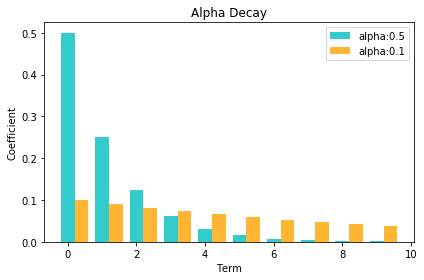

In [3]:
alphaTestData = np.arange(10)
cof_05 = getCofList(alphaTestData, 0.5)
cof_01 = getCofList(alphaTestData, 0.1)
cof_sum_05 = sum(cof_05)
cof_sum_01 = sum(cof_01)
print("Sum of the first 10 coefficients with alpha 0.5:", cof_sum_05)
print("Sum of the first 10 coefficients with alpha 0.1:", cof_sum_01)

# create plot
fig, ax = plt.subplots()

bar_width = 0.4
opacity = 0.8

# create bar graph groups
rects1 = plt.bar(alphaTestData, cof_05, bar_width,
alpha=opacity,
color='c',
label='alpha:0.5')

rects2 = plt.bar(alphaTestData + bar_width, cof_01, bar_width,
alpha=opacity,
color='orange',
label='alpha:0.1')

plt.xlabel('Term')
plt.ylabel('Coefficient')
plt.title('Alpha Decay')
plt.legend()

plt.tight_layout()
plt.show()

In the above plot, we see the relative size of the first 20 coefficients with different alpha values. Each coefficient acts as a weight when multiplied with the signal (value) time series.

**Alpha = 0.5**
- Strongly weights the first (most recent) few values.
- 99.9% of the total weight is allocated to the first 10 coefficients.

**Alpha = 0.1**
- Has a slow decrease in weight from recent to older values.
- Only 65% of the total weight is allocated to the first 10 coefficients.

We can also see that the first coefficient for any series will be equal to alpha.

In the Alpha = 0.1 plot, we will need to use more than 10 coefficients to accurately cover a large percentage of the weight. In fact, we have a smart way of relating alpha and the number of needed coefficients (called the period).

## Relationship Between alpha and period
For *large* alpha values, only a *small* period is needed since the oldest values will have a very small coefficient. Conversely, for *small* alpha values, a *larger* period is needed since more values will have a significantly large coefficient.

A commonly used equation to relate alpha to period is:

**alpha = 2 / ( period + 1 )**

Or written another way:

**period = ( 2 / alpha ) - 1**

This equation allows us to easily compare the exponential moving average to a simple moving average because they can be both written with only the period number. Additionally, using this equation allows us to balance accuracy in the approximation of the EMA with efficiency of not calculating terms that have very low weight.

The simple moving average (SMA) is described using the length of the period that is averaged. In order to easily compare SMAs and EMAs, we want to describe the EMA using only the period, and infer the alpha.

In [4]:
# Calculate the alpha value for a desired period.
def calculateAlpha(ema_period):
    alpha = 2.0 / (ema_period + 1)
    return alpha

## Exponential Moving Average (EMA) Approximation
As written in the below functions, the non-recursive approximation equation for exponential moving average is:

EMA_today = numerator / denominator

numerator   = p1 + (1-a) * p2 + (1-a)<sup>2</sup> * p3 + (1-a)<sup>3</sup> * p4 + (1-a)<sup>4</sup> * p5 + ...

denominator = 1  +  (1-a)  +  (1-a)<sup>2</sup>  +  (1-a)<sup>3</sup>  +  (1-a)<sup>4</sup>  +  ...

Where p1 is the value at the most recent time step (*today*), p2 is the value at the next most recent time step (*yesterday*), and so on.

And a is the rate of decay (a constant between 0 and 1).

In [5]:
# Returns the denominator
def getDenominator(a, number_of_terms):
    # bottom = 1 + (1-a) + (1-a)^2 + (1-a)^3 + ...
    i = 0
    total = 0
    while i < number_of_terms:
        term = (1-a)**i
        total = total + term
        i = i + 1
    return total


# Returns the numerator
def getNumerator(price_data, price_data_index, a, number_of_terms):
    # top = p1 + (1-a)*p2 + (1-a)^2*p3 + (1-a)^3*p4 + ...
    i = 0
    total = 0
    while i < number_of_terms:
        #print("term number:", i)
        price = price_data[price_data_index - i]
        #print("price:", price)
        cof = (1-a)**i
        #print("cof:", cof)
        term = price * cof
        #print("term:", term)
        #print(" ")
        total = total + term
        i = i + 1
    return total


# Returns a single Exponential Moving Average value.
def getEMA(price_data, price_data_index, alpha, number_of_terms):
    #print("index:",price_data_index,"alpha:",alpha,"number_of_terms:",number_of_terms)
    if (number_of_terms - price_data_index) > 1:
        #print("too many terms for this index")
        return 0
    else:
        top = getNumerator(price_data, price_data_index, alpha, number_of_terms)
        bottom = getDenominator(alpha, number_of_terms)
        #print("top:", top)
        #print("bottom:", bottom)
        EMA = top / bottom
        return EMA


# Returns a list of all EMA values.
def getEMAdataset(price_data, alpha, number_of_terms):
    ema_data = []
    i = 0
    while i < len(price_data):
        datum = getEMA(price_data, i, alpha, number_of_terms)
        ema_data.append(datum)
        i = i + 1
    return ema_data



## Plotting Function

In [6]:
# Plots 3 lines: raw data, EMA(period_1), EMA(period_2)
def calculateAndPlotEMA(data, ema_period_1, ema_period_2):
    ema_1 = getEMAdataset(data, ema_period_1)
    ema_2 = getEMAdataset(data, ema_period_2)
    x = np.arange(len(data))
    plt.plot(x, data)
    plt.plot(x, ema_1)
    plt.plot(x, ema_2)
    ema_legend_text_1 = "EMA: " + str(ema_period_1)
    ema_legend_text_2 = "EMA: " + str(ema_period_2)
    plt.legend(['Value', ema_legend_text_1, ema_legend_text_2])
    plt.show()

## Sine Wave Function

In [7]:
# Generates a sine wave.
def generateSineWave(period, amplitude, sigma, start, end):
    # Equations
    alpha = amplitude / 2.0
    beta = 2.0 * np.pi / period
    frequency = 1.0 / period
    x = np.arange(end + 1)
    
    # Formula
    y = alpha * np.sin(beta * x) + sigma
    return y

A Larger alpha responds faster to price, and is less smooth
given the same number of terms.


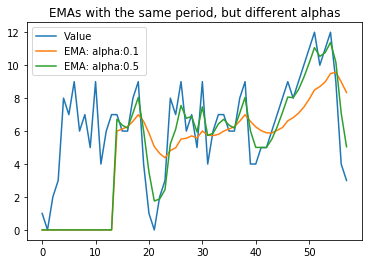

In [8]:
bigData = [1, 0, 2, 3, 8, 7, 9, 6, 7, 5, 9, 4, 6, 7, 7, 6, 6, 8, 9, 4, 
           1, 0, 2, 3, 8, 7, 9, 6, 7, 5, 9, 4, 6, 7, 7, 6, 6, 8, 9, 4,
           4, 5, 5, 6, 7, 8, 9, 8, 9, 10, 11, 12, 10, 11, 12, 9, 4, 3]

x = np.arange(len(bigData))
print("A Larger alpha responds faster to price, and is less smooth")
print("given the same number of terms.")
plt.figure(1)
plt.plot(x, bigData)
ema_data_01_15 = getEMAdataset(bigData, 0.1, 15)
plt.plot(x, ema_data_01_15)
ema_data_05_15 = getEMAdataset(bigData, 0.5, 15)
plt.plot(x, ema_data_05_15)
title = "EMAs with the same period, but different alphas"
plt.title(title)
ema_legend_text_1 = "EMA: alpha:0.1 "
ema_legend_text_2 = "EMA: alpha:0.5"
plt.legend(['Value', ema_legend_text_1, ema_legend_text_2])
plt.show()

A larger number of terms is smoother than a small number with same alpha.


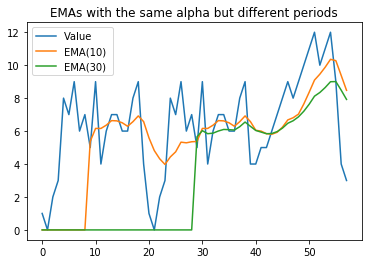

In [9]:
plt.figure(2)
print("A larger number of terms is smoother than a small number with same alpha.")
plt.plot(x, bigData)
ema_data_01_10 = getEMAdataset(bigData, 0.1, 10)
plt.plot(x, ema_data_01_10)
ema_data_01_30 = getEMAdataset(bigData, 0.1, 30)
plt.plot(x, ema_data_01_30)
title = "EMAs with the same alpha but different periods"
plt.title(title)
ema_legend_text_1 = "EMA(10) "
ema_legend_text_2 = "EMA(30)"
plt.legend(['Value', ema_legend_text_1, ema_legend_text_2])
plt.show()

## Function Testing Suite

In [10]:
# Testing Code
testData = [1, 0, 2, 3, 8]

test_EMA1 = getEMA(testData, 2, 0.5, 2)
correctAns1 = 1.333
assert abs(test_EMA1 - correctAns1) < 0.001

test_EMA2 = getEMA(testData, 2, 0.5, 3)
correctAns2 = 1.286
assert abs(test_EMA2 - correctAns2) < 0.001

test_EMA3 = getEMA(testData, 2, 0.5, 4)
correctAns3 = 0.0
assert abs(test_EMA3 - correctAns3) < 0.001

test_cof1 = getCof(alphaTestData, 0.5, 0)
correctAns4 = 0.5
assert abs(test_cof1 - correctAns4) < 0.001

test_cof2 = getCof(alphaTestData, 0.5, 3)
correctAns5 = 0.0625
assert abs(test_cof2 - correctAns5) < 0.001

test_bottom = getDenominator(0.5, 3)
print("test_bottom:", test_bottom)

test_top = getNumerator(testData,2, 0.5, 3)
print("test_top:", test_top)

test_alpha1 = calculateAlpha(9)
correctAns8 = 0.20
assert abs(test_alpha1 - correctAns8) < 0.001


print("ALL TESTS PASSED.")

test_bottom: 1.75
test_top: 2.25
ALL TESTS PASSED.
